In [2]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib

In [124]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [125]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [126]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [7]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [8]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [9]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [10]:
# Import uuid library to generate unique image names
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\061bb318-bd9a-11ec-8e3f-cd24d615af8a.jpg'

In [22]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

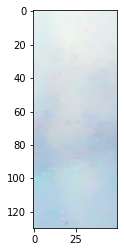

In [17]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [26]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(900)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(900)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(900)

In [27]:
dir_test = anchor.as_numpy_iterator()

In [28]:
print(dir_test.next())

b'data\\anchor\\c7a431e6-bd9a-11ec-9977-cd24d615af8a.jpg'


In [29]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [31]:
img = preprocess('data\\anchor\\c7a431e6-bd9a-11ec-9977-cd24d615af8a.jpg')

In [32]:
img.numpy().max() 

1.0

In [33]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [34]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [35]:
samples = data.as_numpy_iterator()

In [36]:
exampple = samples.next()

In [37]:
exampple = samples.next()

In [38]:
exampple

(b'data\\anchor\\bdcefa5f-bd9b-11ec-b5ab-cd24d615af8a.jpg',
 b'data\\positive\\9e7df4c1-bd9d-11ec-962c-cd24d615af8a.jpg',
 1.0)

In [39]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [40]:
res = preprocess_twin(*exampple)

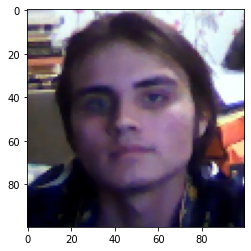

In [41]:
plt.imshow(res[1])

In [42]:
res[2]

1.0

In [43]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [44]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [46]:
inp = Input(shape=(100,100,3), name='input_image')

In [47]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [48]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [49]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [50]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [51]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [52]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [53]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [54]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [55]:
embedding = make_embedding()

In [56]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [63]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [64]:
l1 = L1Dist()

In [66]:
l1

In [67]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [68]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [69]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [70]:
siamese_layer = L1Dist()

In [71]:
distances = siamese_layer(inp_embedding, val_embedding)

In [72]:
classifier = Dense(1, activation='sigmoid')(distances)

In [73]:
classifier


<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [74]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [75]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [76]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [77]:
siamese_model = make_siamese_model()

In [78]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [79]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [80]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [81]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [82]:
test_batch = train_data.as_numpy_iterator()

In [83]:
batch_1 = test_batch.next()

In [84]:
X = batch_1[:2]

In [85]:
y = batch_1[2]

In [86]:
y

array([0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

In [87]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [88]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [89]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [90]:
EPOCHS = 50


In [91]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
79/79 [==============================] - 1558s 20s/step
0.059507634 0.7837838 0.9840319

 Epoch 2/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1518s 19s/step
0.024920113 0.943038 0.99333334

 Epoch 3/50
79/79 [==============================] - 1518s 19s/step
0.08444401 0.9793978 0.9951691

 Epoch 4/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1520s 19s/step
0.088977456 0.96747965 0.9983221

 Epoch 5/50
79/79 [==============================] - 1519s 19s/step
0.022325607 0.9726688 0.9967051

 Epoch 6/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1518s 19s/step
0.00094592414 0.99682033 1.0

 Epoch 7/50
79/79 [==============================] - 1518s 19s/step
0.008948014 1.0 1.0

 Epoch 8/50
79/79 [==============================] - 1515s 19s/step


0.020944672 0.98381877 0.9967213

 Epoch 9/50
79/79 [==============================] - 1516s 19s/step
0.0064328513 0.99841774 1.0

 Epoch 10/50
79/79 [==============================] - 1523s 19s/step
0.008605487 0.9984051 1.0

 Epoch 11/50
1/1 [==============================] - 3s 3s/step


79/79 [==============================] - 1670s 21s/step
0.00048540707 1.0 1.0

 Epoch 12/50
79/79 [==============================] - 1779s 23s/step
0.010298676 1.0 1.0

 Epoch 13/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1649s 21s/step
3.767158e-05 1.0 1.0

 Epoch 14/50
79/79 [==============================] - 1708s 22s/step
0.00032854208 1.0 1.0

 Epoch 15/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1626s 21s/step
0.036674123 0.9907407 0.9953488

 Epoch 16/50
79/79 [==============================] - 1578s 20s/step
0.022412593 0.987055 1.0

 Epoch 17/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1578s 20s/step
0.0020205975 1.0 1.0

 Epoch 18/50
79/79 [==============================] - 1554s 20s/step
2.4438107e-06 1.0 1.0

 Epoch 19/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1569s 20s/step
0.0005082412 1.0 1.0

 Epoch 20/50
79/79 [==============================] - 1537s 19s/step
0.021248147 0.99840766 0.99840766

 Epoch 21/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1646s 21s/step
0.0008406085 1.0 1.0

 Epoch 22/50
79/79 [==============================] - 1698s 21s/step
0.0036129095 0.990566 0.99841523

 Epoch 23/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1502s 19s/step
0.025192821 1.0 1.0

 Epoch 24/50
79/79 [==============================] - 1501s 19s/step
1.4380261e-05 0.99682033 1.0

 Epoch 25/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1502s 19s/step
5.584963e-05 1.0 1.0

 Epoch 26/50
79/79 [==============================] - 1501s 19s/step
0.00025778098 1.0 1.0

 Epoch 27/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1502s 19s/step
1.5397919e-06 1.0 1.0

 Epoch 28/50
79/79 [==============================] - 1502s 19s/step
0.00016893154 1.0 1.0

 Epoch 29/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1502s 19s/step
9.606577e-06 1.0 1.0

 Epoch 30/50
79/79 [==============================] - 1503s 19s/step
8.841701e-06 1.0 1.0

 Epoch 31/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1506s 19s/step
4.3213421e-07 1.0 1.0

 Epoch 32/50
79/79 [==============================] - 1506s 19s/step
3.9736438e-08 1.0 1.0

 Epoch 33/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1503s 19s/step
1.0182706e-05 1.0 1.0

 Epoch 34/50
79/79 [==============================] - 1504s 19s/step
4.9601294e-05 1.0 1.0

 Epoch 35/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1503s 19s/step
1.1871298e-06 1.0 1.0

 Epoch 36/50
79/79 [==============================] - 1502s 19s/step
3.0164645e-05 1.0 1.0

 Epoch 37/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1504s 19s/step
2.0605308e-05 1.0 1.0

 Epoch 38/50
79/79 [==============================] - 1618s 20s/step
4.4703487e-08 1.0 1.0

 Epoch 39/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1545s 20s/step
4.9670547e-08 1.0 1.0

 Epoch 40/50
79/79 [==============================] - 1619s 20s/step
1.3758845e-06 1.0 1.0

 Epoch 41/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1579s 20s/step
9.919084e-05 1.0 1.0

 Epoch 42/50
79/79 [==============================] - 1507s 19s/step
8.136332e-06 1.0 1.0

 Epoch 43/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1506s 19s/step
1.2786153e-05 1.0 1.0

 Epoch 44/50
79/79 [==============================] - 1510s 19s/step
5.314896e-06 1.0 1.0

 Epoch 45/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1508s 19s/step
4.8005488e-05 1.0 1.0

 Epoch 46/50
79/79 [==============================] - 1506s 19s/step
1.0430815e-07 1.0 1.0

 Epoch 47/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1505s 19s/step
0.0 1.0 1.0

 Epoch 48/50
79/79 [==============================] - 1505s 19s/step
2.9588822e-05 1.0 1.0

 Epoch 49/50
1/1 [==============================] - 2s 2s/step


79/79 [==============================] - 1505s 19s/step
1.7086818e-06 1.0 1.0

 Epoch 50/50
79/79 [==============================] - 1504s 19s/step
4.723734e-06 1.0 1.0


In [92]:
from tensorflow.keras.metrics import Precision, Recall

In [93]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [106]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [107]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1]

In [108]:
y_true

array([0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.], dtype=float32)

In [110]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [111]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [112]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 2s 2s/step
1.0 1.0


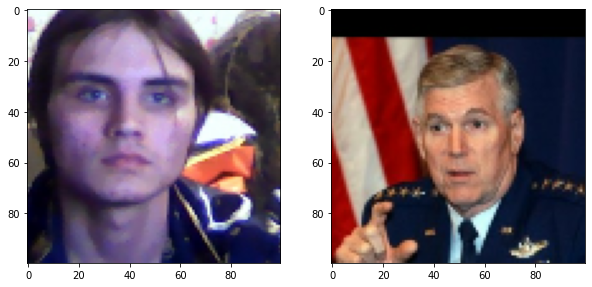

In [116]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[7])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[7])

# Renders cleanly
plt.show()

In [117]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [118]:
L1Dist

__main__.L1Dist

In [119]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [120]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[1.4309139e-10],
       [1.0000000e+00],
       [9.9998426e-01],
       [7.5538805e-13],
       [9.9996346e-01],
       [1.0229323e-10],
       [3.3729117e-05],
       [5.1681813e-15],
       [1.2841671e-08],
       [4.8249356e-11],
       [1.0000000e+00],
       [1.0000000e+00]], dtype=float32)

In [121]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [141]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [171]:
os.listdir(os.path.join('application_data', 'verification_images'))

['005fd767-ba0e-11ec-b753-afdc54415e95.jpg',
 '0067f4e8-ba0e-11ec-8a4b-afdc54415e95 — копия.jpg',
 '0067f4e8-ba0e-11ec-8a4b-afdc54415e95.jpg',
 '006ed99a-ba0e-11ec-8145-afdc54415e95.jpg',
 '00777911-ba0e-11ec-b2d9-afdc54415e95.jpg',
 '007ea3ec-ba0e-11ec-ae83-afdc54415e95.jpg',
 '01062920-ba0e-11ec-958b-afdc54415e95.jpg',
 '012e31d7-ba0e-11ec-84af-afdc54415e95.jpg',
 '01367451-ba0e-11ec-8e3a-afdc54415e95.jpg',
 '01fcd4e4-ba0e-11ec-9c99-afdc54415e95.jpg',
 '02053cf2-ba0e-11ec-b791-afdc54415e95.jpg',
 '031cde00-ba0e-11ec-89a9-afdc54415e95.jpg',
 '0402f74e-ba0e-11ec-8704-afdc54415e95.jpg',
 '042cc51b-ba0e-11ec-94e9-afdc54415e95.jpg',
 '043505bf-ba0e-11ec-85f0-afdc54415e95.jpg',
 '0461d0e7-ba0e-11ec-b9b1-afdc54415e95.jpg',
 '046e3f93-ba0e-11ec-b199-afdc54415e95.jpg',
 '047a579c-ba0e-11ec-8600-afdc54415e95.jpg',
 '0482ab15-ba0e-11ec-b87a-afdc54415e95.jpg',
 '05003cc7-ba0e-11ec-82c2-afdc54415e95.jpg',
 '05255f2e-ba0e-11ec-82a3-afdc54415e95.jpg',
 '052d9ca0-ba0e-11ec-b839-afdc54415e95.jpg',
 '

In [172]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\005fd767-ba0e-11ec-b753-afdc54415e95.jpg
application_data\verification_images\0067f4e8-ba0e-11ec-8a4b-afdc54415e95 — копия.jpg
application_data\verification_images\0067f4e8-ba0e-11ec-8a4b-afdc54415e95.jpg
application_data\verification_images\006ed99a-ba0e-11ec-8145-afdc54415e95.jpg
application_data\verification_images\00777911-ba0e-11ec-b2d9-afdc54415e95.jpg
application_data\verification_images\007ea3ec-ba0e-11ec-ae83-afdc54415e95.jpg
application_data\verification_images\01062920-ba0e-11ec-958b-afdc54415e95.jpg
application_data\verification_images\012e31d7-ba0e-11ec-84af-afdc54415e95.jpg
application_data\verification_images\01367451-ba0e-11ec-8e3a-afdc54415e95.jpg
application_data\verification_images\01fcd4e4-ba0e-11ec-9c99-afdc54415e95.jpg
application_data\verification_images\02053cf2-ba0e-11ec-b791-afdc54415e95.jpg
application_data\verification_images\031cde00-ba0e-11ec-89a9-afdc54415e95.jpg
application_data\verification_images\0402f74e-ba0e-11ec-

In [173]:
def verify(siamese_model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = siamese_model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [174]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.6, 0.8)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 305ms/step
False


In [168]:
np.sum(np.squeeze(results) > 0.9)


17

In [158]:
results

[array([[0.88199526]], dtype=float32),
 array([[0.98684347]], dtype=float32),
 array([[0.9979703]], dtype=float32),
 array([[0.98293346]], dtype=float32),
 array([[0.74441844]], dtype=float32),
 array([[0.972896]], dtype=float32),
 array([[0.9517068]], dtype=float32),
 array([[0.990252]], dtype=float32),
 array([[0.9337988]], dtype=float32),
 array([[0.9956691]], dtype=float32),
 array([[0.9956691]], dtype=float32),
 array([[0.95742494]], dtype=float32),
 array([[0.9914366]], dtype=float32),
 array([[0.89269143]], dtype=float32),
 array([[0.92241126]], dtype=float32),
 array([[0.9288151]], dtype=float32),
 array([[0.97366065]], dtype=float32),
 array([[0.8847694]], dtype=float32),
 array([[0.9120249]], dtype=float32),
 array([[0.98266417]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.00205367]], dtype=float32),
 array([[0.00134599]], dtype=float32),
 array([[0.01183163]], dtype=float32),
 array([[0.05101793]], dtype=float32),
 array([[0.0046

In [ ]:
qq